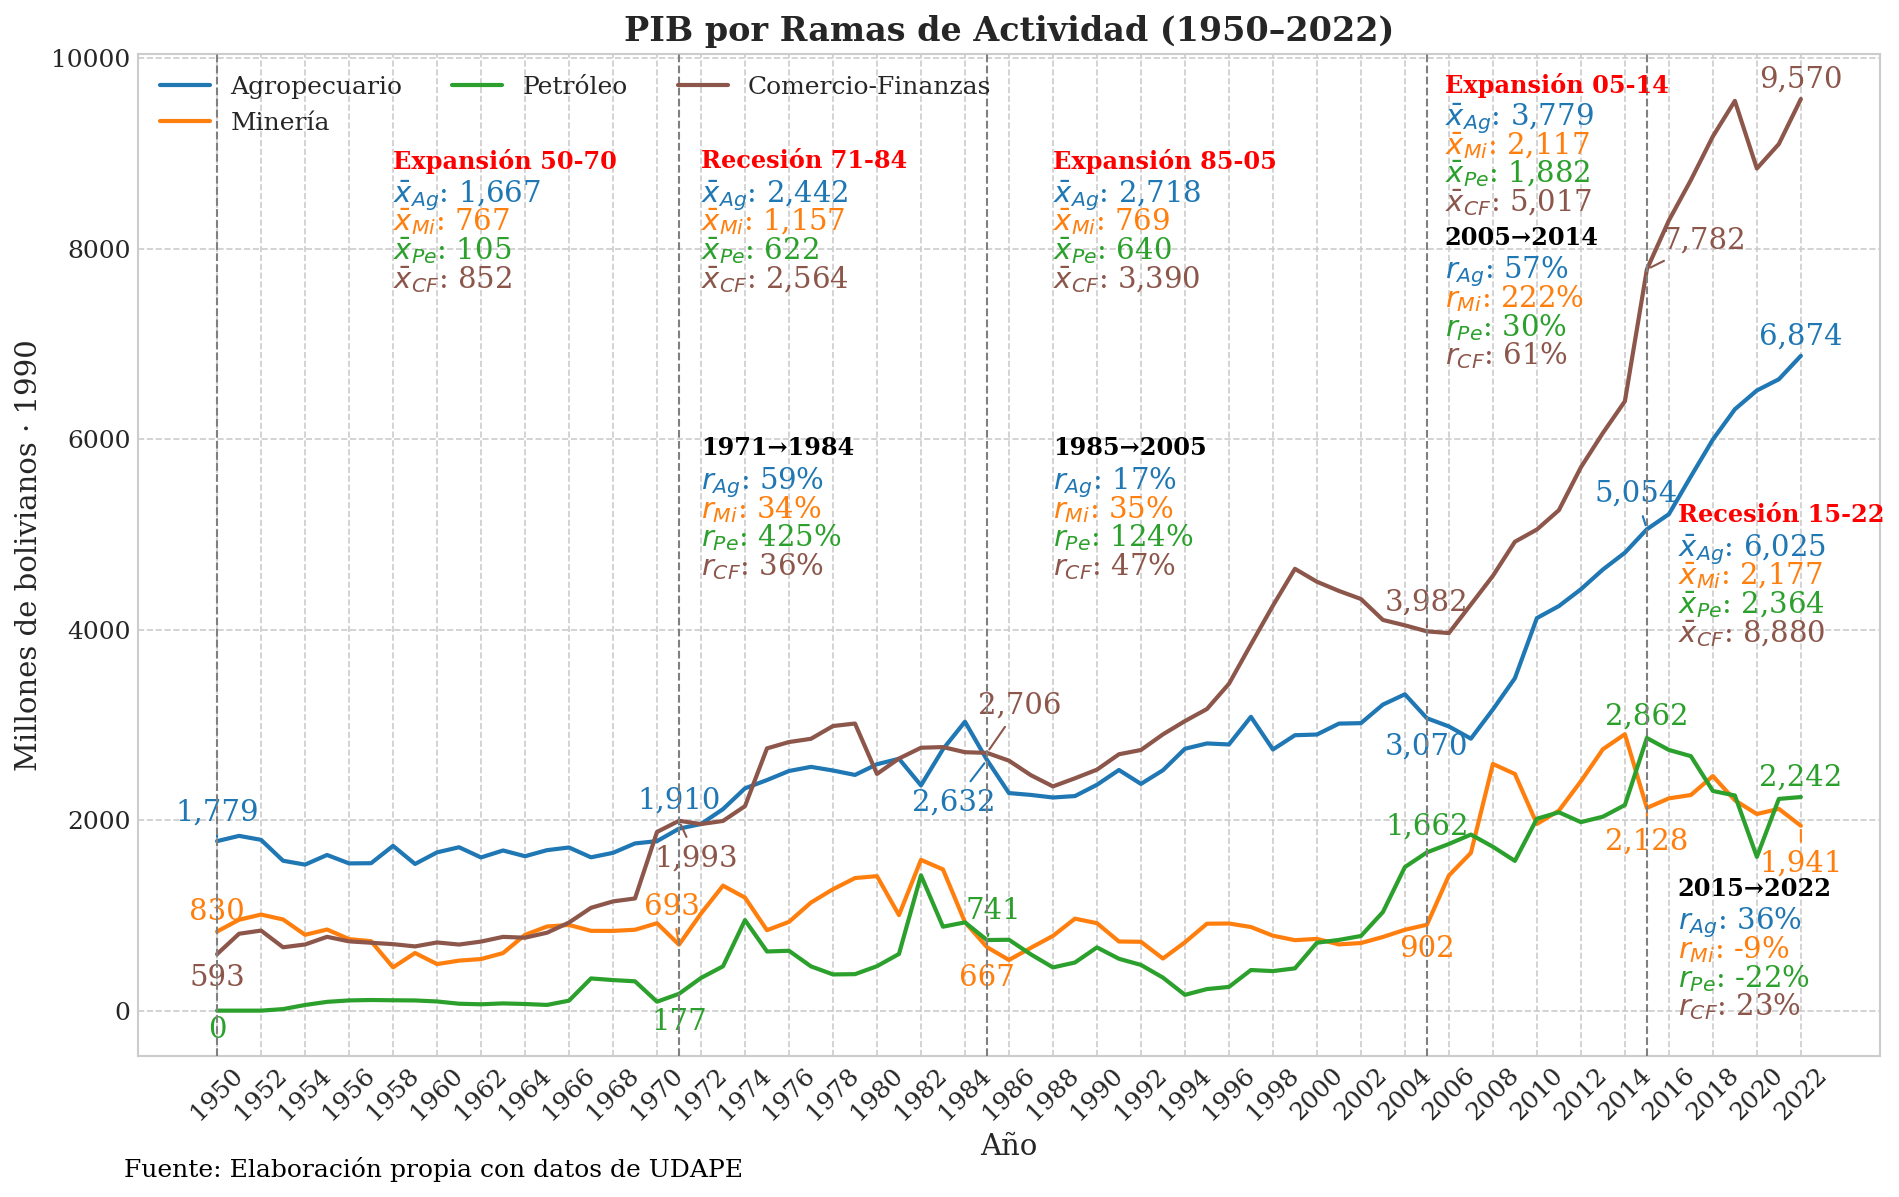

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os, sys
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi
)



EXPANSION_50_70   = slice(1950, 1970)   # Expansión
RECESION_71_84    = slice(1971, 1984)   # Recesión
EXPANSION_85_05   = slice(1985, 2005)   # Expansión
ACUMULACION_05_14 = slice(2005, 2014)   # Acumulación (expansión)
RECESION_15_23    = slice(2015, 2023)   # Recesión
# ── 1. Configuración general ─────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':'serif', 'font.size':12,
    'axes.titlesize':16,   'axes.labelsize':14,
    'grid.linestyle':'--', 'lines.linewidth':2,
    'figure.dpi':150,      'savefig.bbox':'tight'
})

# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM pib_ramas', conn, index_col='año')
            .sort_index()) / 1000        # miles  → millones

sectores = [
    ("agropecuario",      "Agropecuario"),
    ("mineria",           "Minería"),
    ("petroleo",          "Petróleo"),
    ("comercio_finanzas", "Comercio-Finanzas"),
]
cols_sectores = [col for col, _ in sectores]
#estadisticas
avg_expansion_50_70 = df.loc[EXPANSION_50_70, cols_sectores].mean().to_dict()
avg_recesion_71_84  = df.loc[RECESION_71_84, cols_sectores].mean().to_dict()
avg_expansion_85_05 = df.loc[EXPANSION_85_05, cols_sectores].mean().to_dict()
avg_expansion_05_14 = df.loc[ACUMULACION_05_14, cols_sectores].mean().to_dict()
avg_recesion_15_23  = df.loc[RECESION_15_23, cols_sectores].mean().to_dict()

# ── 4. Hitos, años clave, offsets ────────────────────────────────────
hitos_v = {
    1950: "Expansion",
    1971: "Recesion",
    1985: "Expansion",
    2005: "Expansion",
    2015: "Recesion"
}

anot_years = [1950,1971,1985, 2005, 2015,2022]

# añade (dx,dy) solo si quieres mover textos manualmente
annotation_offsets = {
    "agropecuario": {
        1950: (0, 300), 1971: (0, 300), 1985: (-1.5, -450),
        2005: (0, -300), 2015: (-0.5, 370),2022:(0,200)
    },
    "mineria": {
        1950: (0, 200), 1971: (-0.3, 400), 1985: (0, -320),
        2005: (0, -250), 2015: (0, -350),2022:(0,-400)
    },
    "petroleo": {
        1950: (0, -200), 1971: (0, -300),1985: (0.3, 300),
        2005: (0, 270),
        2015: (0, 220),
        2022:(0,200)
    },
    "comercio_finanzas": {
        1950: (0, -250), 1971: (0.8, -400), 1985: (1.5, 500),
        2005: (0, 300),
        2015: (2.6, 300),
        2022:(0,200)
    },
}
# hitos_offset: año → fracción de eje Y (0–1) donde apoya la base del recuadro
hitos_offset = {
    1950: 0.45, 1971: 0.50, 1985: 0.50,
    2005: 0.62, 2015: 0.48
}
annotation_tasas_offsets = {
    'agropecuario': {
        1970: (0,   9000),   # desplaza la etiqueta 1956→1970
        1986: (-2.3,  8900),   # desplaza la etiqueta 1970→1986
        2006: (-3.5,   800),   # desplaza la etiqueta 1986→2006
        2014: (-0.9,  -4600),   # desplaza la etiqueta 2006→2014
        2022: (1,-5200)
    }
}
# ── 5. Gráfico ───────────────────────────────────────────────────────
custom_colors = {
    "agropecuario":      "#1f77b4",  # blue
    "mineria":           "#ff7f0e",  # orange
    "petroleo":          "#2ca02c",  # green
    "comercio_finanzas": "#8c564b",  # café
}

fig, ax = plt.subplots(figsize=(13,8))
for col, label in sectores:
    ax.plot(df.index, df[col],
            label=label,
            color=custom_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
for yr, lbl in hitos_v.items():
    if yr in df.index:
        ax.axvline(x=yr, color='gray', linestyle='--', linewidth=1, zorder=5)
        y_max = ax.get_ylim()[1]
        offset = hitos_offset.get(yr, 0.82)   # fallback si falta
        if lbl=='Crisis':
            ax.text(yr, y_max * offset, lbl,
                    rotation=90, ha='right', va='top',
                    fontsize=14, color='gray',
                    bbox=dict(facecolor='#f0f0f0', alpha=0.6, edgecolor='none'),
                    zorder=6)

# ── 7. Anotaciones de valores ────────────────────────────────────────
for yr in anot_years:
    if yr not in df.index:
        continue
    vals = [(df.loc[yr, col], col) for col, _ in sectores]
    vals.sort(key=lambda t: t[0])  # de menor a mayor
    for y, col in vals:
        dx, dy = annotation_offsets.get(col, {}).get(yr, (0, 0))
        ax.annotate(f"{y:,.0f}",
                    xy=(yr, y), xytext=(yr + dx, y + dy),
                    ha='center', va='center',
                    fontsize=14, color=custom_colors[col],
                    arrowprops=dict(arrowstyle='-',
                                    color=custom_colors[col], lw=1))
        
# Mapa de tasas por año final
periodos = [
    (1971, 1984),
    (1985, 2005),
    (2005, 2014),
    (2015,2022)
]
componentes = ["agropecuario", "mineria", "comercio_finanzas", "petroleo"]



#cuadro de estadisticas
# 8.1 Abreviaturas para las ramas
abbr = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "petroleo":          "Pe",
    "comercio_finanzas": "CF",
}

# 8.2 Estadísticas promedio por ciclo (ya calculadas arriba)
cycle_stats = {
    "Expansión 50-70": avg_expansion_50_70,
    "Recesión 71-84":  avg_recesion_71_84,
    "Expansión 85-05": avg_expansion_85_05,
    "Expansión 05-14": avg_expansion_05_14,
    "Recesión 15-22":  avg_recesion_15_23,
}

# 8.3 Colores de cada rama (mismo diccionario de la línea)
component_colors = custom_colors

text_offsets = {
    "Expansión 50-70": (1958,  0.90),
    "Recesión 71-84":  (1972,  0.90),
    "Expansión 85-05": (1988,  0.90),
    "Expansión 05-14": (2005.8,  0.98),
    "Recesión 15-22": (2016.4,  0.53),
}
# calcula y_max DESPUÉS de haber dibujado las series
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03          # 3 % de la altura

add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr,
    component_colors,
    line_spacing=line_spacing,        # ← pasa el valor correcto
)


# 2. Parámetros de posición y estilo (sobre tu ax ya dibujado)
y_max       = ax.get_ylim()[1]
line_space  = y_max * 0.03
# abreviaturas para cada componente
abbr_comp   = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "comercio_finanzas": "CF",
    "petroleo":          "Pe",
}
# 3. Coordenadas aproximadas para cada periodo
period_offsets = {
    "1971-1984": (1972,  0.60),
    "1985-2005": (1988,  0.60),
    "2005-2014": (2005.8,  0.82),
    "2015-2022": (2016.4, 0.14),
}

# 4. Loop para anotar cada cuadro de tasas
add_period_growth_annotations_multi(
    ax,df,
    periodos,
    [col for col,_ in sectores],
    period_offsets,
    component_colors,
    abbr_comp,
)
# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"PIB por Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=3, fontsize=12)
# ── Pie de fuente ─────────────────────────────────────────────────────────
fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_rama_de_actividad_1.png"))
plt.show()

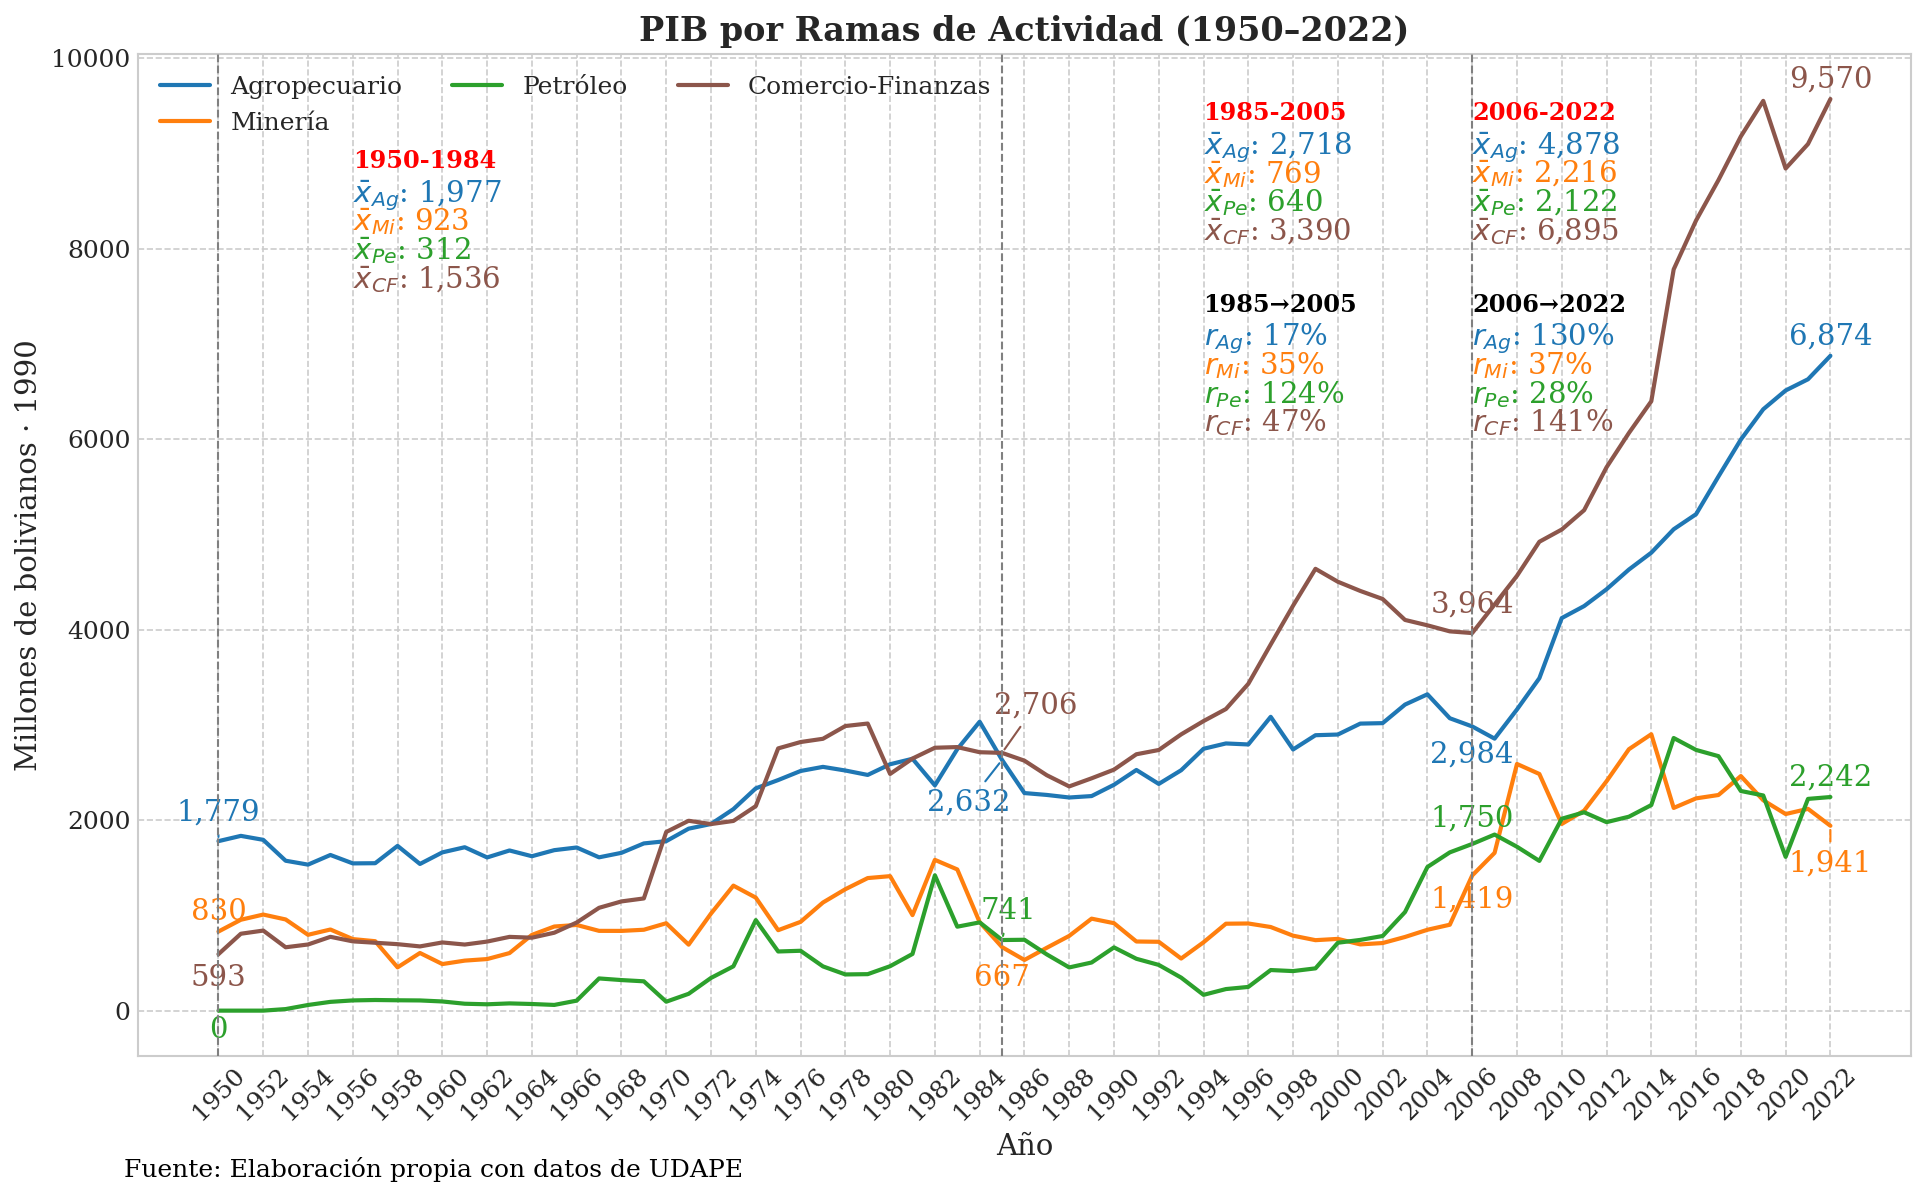

In [2]:
PERIODO_1 = slice(1950, 1984)   # Crisis
PERIODO_2 = slice(1985, 2005)   # Expansión
PERIODO_3 = slice(2006, 2022)   # Recesión



sectores = [
    ("agropecuario",      "Agropecuario"),
    ("mineria",           "Minería"),
    ("petroleo",          "Petróleo"),
    ("comercio_finanzas", "Comercio-Finanzas"),
]
cols_sectores = [col for col, _ in sectores]
#estadisticas
avg_periodo_1 = df.loc[PERIODO_1, cols_sectores].mean().to_dict()
avg_periodo_2  = df.loc[PERIODO_2, cols_sectores].mean().to_dict()
avg_periodo_3 = df.loc[PERIODO_3, cols_sectores].mean().to_dict()


# ── 4. Hitos, años clave, offsets ────────────────────────────────────
hitos_v = {
    1950: "1950-1984",
    1985: "1985-2005",
    2006: "2006-2022",
}


anot_years = [1950,1985,2006,2022]

# añade (dx,dy) solo si quieres mover textos manualmente
annotation_offsets = {
    "agropecuario": {
        1950: (0, 300), 1985: (-1.5, -450),
        2006: (0, -300), 2022:(0,200)
    },
    "mineria": {
        1950: (0, 200), 1985: (0, -320),
        2006: (0, -250), 2022:(0,-400)
    },
    "petroleo": {
        1950: (0, -200), 1985: (0.3, 300),
        2006: (0, 270),
        2022:(0,200)
    },
    "comercio_finanzas": {
        1950: (0, -250), 1985: (1.5, 500),
        2006: (0, 300),
        2022:(0,200)
    },
}
period_offsets = {
    "1950-1984": (1956,  0.60),
    "1985-2005": (1994,  0.75),
    "2006-2022": (2006,  0.75),
}
text_offsets = {
    "1950-1984": (1956,  0.90),
    "1985-2005":  (1994,  0.95),
    "2006-2022": (2006,  0.95),

}
# hitos_offset: año → fracción de eje Y (0–1) donde apoya la base del recuadro
hitos_offset = {
    1950: 0.45, 1985: 0.50, 2006: 0.50,
}
annotation_tasas_offsets = {
    'agropecuario': {
        1970: (0,   9000),   # desplaza la etiqueta 1956→1970
        1986: (-2.3,  8900),   # desplaza la etiqueta 1970→1986
        2006: (-3.5,   800),   # desplaza la etiqueta 1986→2006
        2014: (-0.9,  -4600),   # desplaza la etiqueta 2006→2014
        2022: (1,-5200)
    }
}
# ── 5. Gráfico ───────────────────────────────────────────────────────
custom_colors = {
    "agropecuario":      "#1f77b4",  # blue
    "mineria":           "#ff7f0e",  # orange
    "petroleo":          "#2ca02c",  # green
    "comercio_finanzas": "#8c564b",  # café
}

fig, ax = plt.subplots(figsize=(13,8))
for col, label in sectores:
    ax.plot(df.index, df[col],
            label=label,
            color=custom_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
for yr, lbl in hitos_v.items():
    if yr in df.index:
        ax.axvline(x=yr, color='gray', linestyle='--', linewidth=1, zorder=5)
        y_max = ax.get_ylim()[1]
        offset = hitos_offset.get(yr, 0.82)   # fallback si falta
        if lbl=='Crisis':
            ax.text(yr, y_max * offset, lbl,
                    rotation=90, ha='right', va='top',
                    fontsize=14, color='gray',
                    bbox=dict(facecolor='#f0f0f0', alpha=0.6, edgecolor='none'),
                    zorder=6)

# ── 7. Anotaciones de valores ────────────────────────────────────────
for yr in anot_years:
    if yr not in df.index:
        continue
    vals = [(df.loc[yr, col], col) for col, _ in sectores]
    vals.sort(key=lambda t: t[0])  # de menor a mayor
    for y, col in vals:
        dx, dy = annotation_offsets.get(col, {}).get(yr, (0, 0))
        ax.annotate(f"{y:,.0f}",
                    xy=(yr, y), xytext=(yr + dx, y + dy),
                    ha='center', va='center',
                    fontsize=14, color=custom_colors[col],
                    arrowprops=dict(arrowstyle='-',
                                    color=custom_colors[col], lw=1))
        
# Mapa de tasas por año final
periodos = [
    (1985, 2005),
    (2006, 2022)
]
componentes = ["agropecuario", "mineria", "comercio_finanzas", "petroleo"]



#cuadro de estadisticas
# 8.1 Abreviaturas para las ramas
abbr = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "petroleo":          "Pe",
    "comercio_finanzas": "CF",
}

# 8.2 Estadísticas promedio por ciclo (ya calculadas arriba)
cycle_stats = {
    "1950-1984":   avg_periodo_1,
    "1985-2005":   avg_periodo_2,
    "2006-2022":   avg_periodo_3,
}

# 8.3 Colores de cada rama (mismo diccionario de la línea)
component_colors = custom_colors


# calcula y_max DESPUÉS de haber dibujado las series
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03          # 3 % de la altura

add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr,
    component_colors,
    line_spacing=line_spacing,        # ← pasa el valor correcto
)


# 2. Parámetros de posición y estilo (sobre tu ax ya dibujado)
y_max       = ax.get_ylim()[1]
line_space  = y_max * 0.03
# abreviaturas para cada componente
abbr_comp   = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "comercio_finanzas": "CF",
    "petroleo":          "Pe",
}
# 3. Coordenadas aproximadas para cada periodo


# 4. Loop para anotar cada cuadro de tasas
add_period_growth_annotations_multi(
    ax,df,
    periodos,
    [col for col,_ in sectores],
    period_offsets,
    component_colors,
    abbr_comp,
)
# ── 8. Ajustes finales ───────────────────────────────────────────────
ax.set_title(f"PIB por Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=3, fontsize=12)
# ── Pie de fuente ─────────────────────────────────────────────────────────
fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_rama_de_actividad_2.png"))
plt.show()